In [3]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path

from utils import model_utils, file_utils, data_processing_utils
import config

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
start_date = '2013-01-01'
end_date = '2017-12-31'
tickers = ['PETR4']
tech_indicators = config.INDICATORS

df = data_processing_utils.get_data(
    start_date=start_date,
    end_date=end_date,
    tickers=tickers,
    tech_indicators=tech_indicators
)

df

NameError: name 'config' is not defined

In [5]:
HYPERPARAMETERS_PATH = 'HYPERPARAMETER_TUNING\PETR4\DDPG_HMAX_200'

In [6]:
env_kwargs = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'env_train_kwargs.json'), 'r'))
args = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'command_line_args.json'), 'r'))
print(env_kwargs, '\n')
print(args)

{'stock_dim': 1, 'hmax': 200, 'initial_amount': 200000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 14, 'action_space': 1, 'tech_indicator_list': ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'turbulence_threshold': None, 'print_verbosity': 1000} 

{'alg': 'DDPG', 'tickers': ['PETR4.SA'], 'tuning_timesteps': 200000, 'train_timesteps': 200000, 'train_period': ['2013-01-01', '2017-12-31'], 'eval_period': ['2018-01-01', '2018-12-31'], 'trade_period': ['2019-01-01', '2021-12-31'], 'indicators': ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'hmax': 200, 'use_ohlcv': False, 'initial_amount': 200000, 'n_trials': 100, 'n_repeats_by_trial': 3, 'output_path': '', 'metric_to_optimize': 'Cumulative returns', 'n_eval_episodes': 1, 'use_best_model': True}


In [21]:
TEST_PATH = file_utils.uniquify(os.path.join('TESTS', '_'.join(args['tickers']), args['alg']))
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'monitor_logs'), exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'tb_log'), exist_ok=True)

In [8]:
df_hyperparameters = pd.read_csv(os.path.join(HYPERPARAMETERS_PATH, 'hp_tuning_hist.csv'))
df_hyperparameters_group = df_hyperparameters.groupby(['trial', 'hyperparameters']).agg(['mean', 'std']).reset_index()
df_hyperparameters_group = df_hyperparameters_group.sort_values(('metric', 'mean'), ascending=False)

display(df_hyperparameters_group.head())

print('Best Trial: {} | Mean Metric: {:.4f} +- {:.4f}'.format(
    df_hyperparameters_group.iloc[0]['trial'][0], 
    df_hyperparameters_group.iloc[0][('metric', 'mean')],
    df_hyperparameters_group.iloc[0][('metric', 'std')],
    
    )
)

best_params = eval(df_hyperparameters_group.iloc[0]['hyperparameters'][0])
best_params = model_utils.load_params_from_store_format(best_params)

best_params

trial                                    hyperparameters    metric          
                                                                mean       std
1     1  {'gamma': 0.98, 'learning_starts': 20000, 'lea...  0.141578  0.132950
2     4  {'gamma': 0.99, 'learning_starts': 20000, 'lea...  0.117214  0.102592
0     0  {'gamma': 0.99, 'learning_starts': 20000, 'lea...  0.064740  0.079948

Best Trial: 1 | Mean Metric: 0.1416 +- 0.1330


{'gamma': 0.98,
 'learning_starts': 20000,
 'learning_rate': 0.00999930215461977,
 'batch_size': 2048,
 'buffer_size': 1000000,
 'train_freq': (1, 'episode'),
 'gradient_steps': 8,
 'policy_kwargs': {'net_arch': [256, 256]}}

In [9]:
df_hyperparameters

,trial,metric,hyperparameters
0,0,0.011258,"{'gamma': 0.99, 'learning_starts': 20000, 'lea..."
1,0,0.026317,"{'gamma': 0.99, 'learning_starts': 20000, 'lea..."
2,0,0.156646,"{'gamma': 0.99, 'learning_starts': 20000, 'lea..."
3,1,0.263772,"{'gamma': 0.98, 'learning_starts': 20000, 'lea..."
4,1,0.160961,"{'gamma': 0.98, 'learning_starts': 20000, 'lea..."
5,1,0.000000,"{'gamma': 0.98, 'learning_starts': 20000, 'lea..."
6,4,0.190680,"{'gamma': 0.99, 'learning_starts': 20000, 'lea..."
7,4,0.000000,"{'gamma': 0.99, 'learning_starts': 20000, 'lea..."
8,4,0.160961,"{'gamma': 0.99, 'learning_starts': 20000, 'lea..."


In [10]:
df_hyperparameters.sort_values('metric', ascending=False)['hyperparameters'].apply(lambda x: eval(x)['train_freq']).head(50)

3    (1, episode)
6    (3, episode)
4    (1, episode)
8    (3, episode)
2    (3, episode)
1    (3, episode)
0    (3, episode)
5    (1, episode)
7    (3, episode)
Name: hyperparameters, dtype: object

In [19]:
args['eval_period'][1]

'2018-12-31'

In [53]:
df = pd.read_pickle(os.path.join(HYPERPARAMETERS_PATH, 'dataset.pkl'))

train_set = data_split(df, args['train_period'][0], args['eval_period'][1])
eval_set = data_split(df, args['eval_period'][0], args['eval_period'][1])
trade_set = data_split(df, args['trade_period'][0], args['trade_period'][1])
# trade_set = data_split(df, args['trade_period'][0], '2019-12-31')

trade_set['date'] = pd.to_datetime(trade_set['date'])

print('Train\t', train_set['close'].iloc[-1] / train_set['close'].iloc[0] - 1)
print('Eval\t', eval_set['close'].iloc[-1] / eval_set['close'].iloc[0] - 1)
print('Trade\t', trade_set['close'].iloc[-1] / trade_set['close'].iloc[0] - 1)

Train	 0.3059543824392972
Eval	 0.4295947078931699
Trade	 0.5080038562261386


In [62]:
# RE-TRAINING
e_train_gym = StockTradingEnv(
    df=train_set, 
    **env_kwargs
)

env_train = DummyVecEnv([lambda: e_train_gym])
env_train = VecMonitor(
    env_train, 
    os.path.join(
        TEST_PATH,
        'monitor_logs',
        'log_retrain'
    )
)
env_train = VecNormalize(
    env_train, 
    training=True,
    norm_obs=True, 
    norm_reward=True,
    gamma=best_params['gamma']
)


MODEL = model_utils.get_model(args['alg'])
retrained_model = MODEL(
    policy='MlpPolicy', 
    env=env_train,
    **best_params,
    verbose=True,
    seed=None,
    tensorboard_log=os.path.join(
        os.path.join(TEST_PATH, 'tb_log')
    )
)

retrained_model = retrained_model.learn(
    tb_log_name='RE_TRAINING',
    log_interval=1,
    total_timesteps=115330,
    reset_num_timesteps=True
)

Using cuda device
Logging to TESTS\PETR4.SA\DDPG_1\tb_log\RE_TRAINING_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.45e+03 |
|    ep_rew_mean     | 20218.94 |
| time/              |          |
|    episodes        | 1        |
|    fps             | 778      |
|    time_elapsed    | 1        |
|    total_timesteps | 1453     |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.45e+03  |
|    ep_rew_mean     | 25138.965 |
| time/              |           |
|    episodes        | 2         |
|    fps             | 800       |
|    time_elapsed    | 3         |
|    total_timesteps | 2906      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.45e+03  |
|    ep_rew_mean     | 15159.297 |
| time/              |           |
|    episodes        | 3         |
|    fps             | 827  

In [59]:
env_eval.ret_rms.mean

409.9555930367889

In [61]:
e_eval_gym = StockTradingEnv(df=trade_set, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])
env_eval = VecMonitor(
    env_eval, 
    os.path.join(
        TEST_PATH,
        'monitor_logs',
        'log_trade'
    )
)
env_eval = VecNormalize(
    env_eval, 
    training=False,
    norm_obs=True, 
    norm_reward=False,
    gamma=best_params['gamma']
)

sync_envs_normalization(env_train, env_eval)

In [40]:
env_kwargs

{'stock_dim': 1,
 'hmax': 200,
 'initial_amount': 200000,
 'num_stock_shares': [0],
 'buy_cost_pct': [0.001],
 'sell_cost_pct': [0.001],
 'reward_scaling': 1,
 'state_space': 14,
 'action_space': 1,
 'tech_indicator_list': ['macd',
  'boll_ub',
  'boll_lb',
  'rsi_30',
  'stochrsi_30',
  'wr_30',
  'vwma_30',
  'cci_30',
  'dx_30',
  'close_30_sma',
  'close_60_sma'],
 'turbulence_threshold': None,
 'print_verbosity': 1000}

1.0


<AxesSubplot:xlabel='date', ylabel='account_value'>

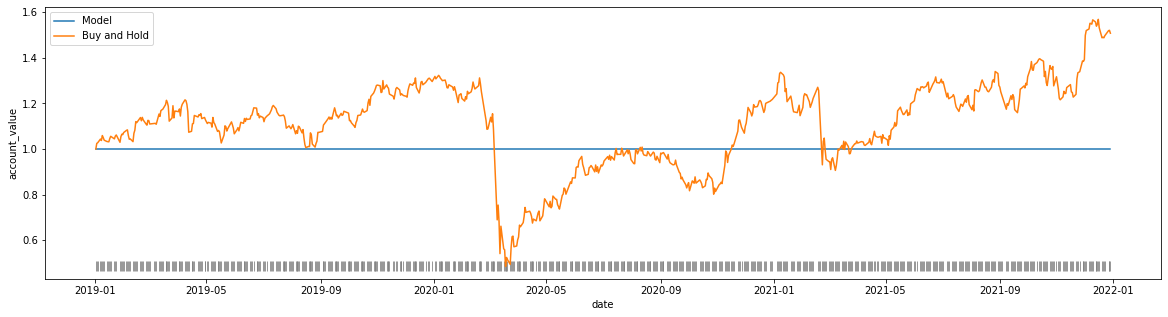

In [58]:
from stable_baselines3.common.vec_env import sync_envs_normalization

e_eval_gym = StockTradingEnv(df=trade_set, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])
env_eval = VecMonitor(
    env_eval, 
    os.path.join(
        TEST_PATH,
        'monitor_logs',
        'log_trade'
    )
)
env_eval = VecNormalize(
    env_eval, 
    training=False,
    norm_obs=True, 
    norm_reward=False,
    gamma=best_params['gamma']
)

sync_envs_normalization(env_train, env_eval)

account_memory, actions_memory, state_memory = model_utils.predict(
    retrained_model, 
    env_eval, 
    True
)

cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
cum_return_beh = (trade_set['close'].pct_change(1)+1).cumprod().fillna(1)

actions_plot = np.where(
    actions_memory['actions'] > 0, 
    'green', 
    np.where(actions_memory['actions'] < 0,
        'red',
        'gray'
    )
).tolist() + ['gray']

print(cum_return_model.iloc[-1])

plt.figure(figsize=(20,5))
sns.lineplot(x=trade_set['date'], y=cum_return_model, label='Model')
sns.lineplot(x=trade_set['date'], y=cum_return_beh, label='Buy and Hold')


sns.scatterplot(x=trade_set['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)

USANDO BEST MODEL
TIMESTEPS: 115330
1.3051527061712984


<AxesSubplot:xlabel='date', ylabel='account_value'>

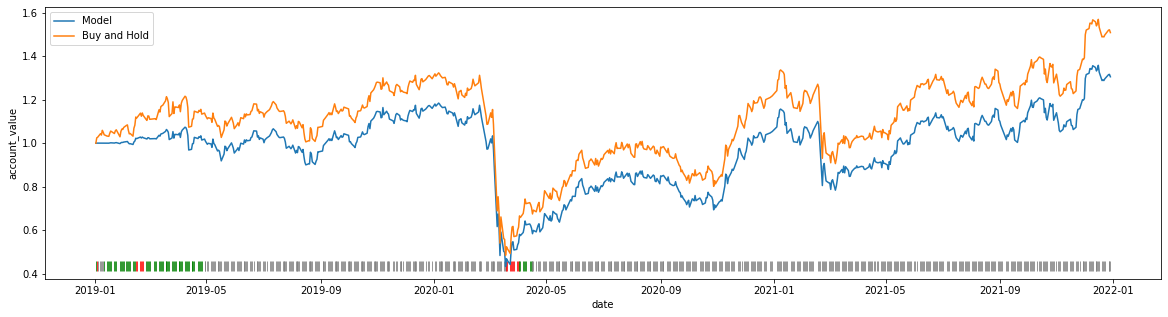

In [26]:
a = 1
b = 0

type = 'best'

e_eval_gym = StockTradingEnv(df=trade_set, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])

if args['use_best_model']:
    env_statistics_path = os.path.join(
        HYPERPARAMETERS_PATH, 
        'models',
        'TRIAL_{}_REPEAT_{}'.format(a, b),
        f'env_statistics_{type}'
    )

    env_eval = VecNormalize.load(
        env_statistics_path,
        env_eval,
    )
    env_eval.training = False
    env_eval.norm_reward = False

    best_model_path = os.path.join(
        HYPERPARAMETERS_PATH, 
        f'models',
        'TRIAL_{}_REPEAT_{}'.format(a, b),
        f'model_{type}.zip'
    )

    MODEL = model_utils.get_model(args['alg'])
    trained_model = MODEL.load(best_model_path, env_eval)

    print('USANDO BEST MODEL')
    print('TIMESTEPS:', trained_model.num_timesteps)


account_memory, actions_memory, state_memory = model_utils.predict(
    trained_model, 
    env_eval, 
    True
)

cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
cum_return_beh = (trade_set['close'].pct_change(1)+1).cumprod().fillna(1)

actions_plot = np.where(
    actions_memory['actions'] > 0, 
    'green', 
    np.where(actions_memory['actions'] < 0,
        'red',
        'gray'
    )
).tolist() + ['gray']

print(cum_return_model.iloc[-1])

plt.figure(figsize=(20,5))
sns.lineplot(x=trade_set['date'], y=cum_return_model, label='Model')
sns.lineplot(x=trade_set['date'], y=cum_return_beh, label='Buy and Hold')


sns.scatterplot(x=trade_set['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)


In [189]:
actions_memory[actions_memory['actions'] != 0]

,date,actions
0,2019-01-02,[113]
1,2019-01-03,[114]
2,2019-01-04,[113]
3,2019-01-07,[112]
4,2019-01-08,[115]
5,2019-01-09,[119]
6,2019-01-10,[120]
7,2019-01-11,[121]
8,2019-01-14,[124]
9,2019-01-15,[65]


In [56]:
# from stable_baselines3.common.evaluation import evaluate_policy

# evaluate_policy(
#     trained_model,
#     env_eval,
#     n_eval_episodes=2,
#     render=False,
#     deterministic=True,
#     return_episode_rewards=True
# )

([19009.36766976118, 19009.36766976118], [239, 239])

{'gamma': 0.9999,
 'learning_rate': 3.531598691003717e-06,
 'batch_size': 1024,
 'buffer_size': 1000000,
 'train_freq': 8,
 'gradient_steps': 8,
 'policy_kwargs': {'net_arch': [256, 256]}}

In [15]:


for n_repeat in range(10):

    # ENV TRAIN
    e_train_gym = StockTradingEnv(
        df=train_set, 
        **env_kwargs
    )
    env_train = DummyVecEnv([lambda: e_train_gym])
    env_train = VecMonitor(
        env_train, 
        os.path.join(
            TEST_PATH,
            'monitor_logs',
            'log_train_{}'.format(str(n_repeat))
        )
    )
    env_train = VecNormalize(
        env_train, 
        training=True,
        norm_obs=True, 
        norm_reward=True,
        gamma=best_params['gamma']
    )

    MODEL = model_utils.get_model(args['alg'])
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **best_params,
        verbose=True,
        seed=None,
        tensorboard_log=os.path.join(
            TEST_PATH,
            './tb_log'
        )
    )

    trained_model = model.learn(
        tb_log_name='TEST_{}'.format(str(n_repeat)),
        log_interval=1,
        total_timesteps=50000,
        reset_num_timesteps=True
    )

    



    e_eval_gym = StockTradingEnv(df = eval_set, **env_kwargs)
    env_eval = DummyVecEnv([lambda: e_eval_gym])
    
    env_eval = VecNormalize(
        env_eval, 
        training=False,
        norm_obs=True, 
        norm_reward=False,
        gamma=best_params['gamma']
    )

    MODEL = model_utils.get_model(args['alg'])
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **best_params,
        verbose=True,
        seed=None,
        tensorboard_log=os.path.join(
            TEST_PATH,
            './tb_log'
        )
    )



    account_memory, actions_memory = model_utils.predict(trained_model, env_trade)
    test_result = account_memory['account_value'].iloc[-1] / account_memory['account_value'].iloc[0] - 1

    RESULTS_FILE_PATH = os.path.join(TEST_PATH, 'results.csv')

    if not Path(RESULTS_FILE_PATH).exists():
        pd.DataFrame([{'Test': n_repeat, 'Result': test_result}]).to_csv(
            RESULTS_FILE_PATH
        )
    else:
        pd.DataFrame([{'Test': n_repeat, 'Result': test_result}]).to_csv(
            RESULTS_FILE_PATH, mode='a', header=False
        )




Wrapping the env in a DummyVecEnv.


IndexError: invalid index to scalar variable.